In [54]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [55]:
!pip install patool

In [56]:
import patoolib

patoolib.extract_archive('Dataset Blur or HD.zip')

INFO patool: Extracting Dataset Blur or HD.zip ...
INFO:patool:Extracting Dataset Blur or HD.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_gd_vwc3z -- "Dataset Blur or HD.zip"
INFO:patool:running /usr/bin/7z x -o./Unpack_gd_vwc3z -- "Dataset Blur or HD.zip"
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... Dataset Blur or HD.zip extracted to `Dataset Blur or HD'.
INFO:patool:... Dataset Blur or HD.zip extracted to `Dataset Blur or HD'.


'Dataset Blur or HD'

In [62]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your dataset directory
dataset_dir = '/content/Dataset Blur or HD'

# The paths for the training and validation directories
train_dir = '/content/working/training'
val_dir = '/content/working/validation'

# The categories of your gym equipment
categories = ['Blur','HD']

# Split ratio for validation
val_split_ratio = 0.2

# Create the training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for category in categories:
    # Create category-specific subdirectories in both the training and validation directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    # Get the full path for the current category
    category_path = os.path.join(dataset_dir, category)

    # Check if the category path exists
    if not os.path.exists(category_path):
        print(f"Category path does not exist: {category_path}")
        continue

    # List all files in the category directory
    all_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    # Split the files into training and validation sets
    train_files, val_files = train_test_split(all_files, test_size=val_split_ratio)

    # Copy the training files to the training directory
    for file_name in train_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(train_dir, category, file_name))

    # Copy the validation files to the validation directory
    for file_name in val_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(val_dir, category, file_name))


In [58]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [63]:
# Define paths
base_dir = '/content/working/'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')

In [64]:
# Define image dimensions
img_width, img_height = 224, 224
batch_size = 32

In [65]:
# Data augmentation configuration for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 161 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [66]:
# Load MobileNetV2 as base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model


In [67]:
# Define the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')  # Final output layer with 2 classes
])

In [68]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [81]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.96):
            print('\nReached 90% accuracy for both training and validation. Stopping training.')
            self.model.stop_training = True

callback = AccuracyThresholdCallback()

In [82]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1000,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback]
)


Epoch 1/1000
5/5 [==============================] - 12s 2s/step - loss: 0.0350 - accuracy: 0.9875 - val_loss: 0.2616 - val_accuracy: 0.9375
Epoch 2/1000
5/5 [==============================] - 10s 2s/step - loss: 0.0238 - accuracy: 0.9922 - val_loss: 0.1334 - val_accuracy: 0.9375
Epoch 3/1000
5/5 [==============================] - 10s 2s/step - loss: 0.0368 - accuracy: 0.9922 - val_loss: 0.2591 - val_accuracy: 0.9062
Epoch 4/1000
5/5 [==============================] - 10s 2s/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.3012 - val_accuracy: 0.8438
Epoch 5/1000
5/5 [==============================] - 10s 2s/step - loss: 0.0264 - accuracy: 0.9845 - val_loss: 0.2667 - val_accuracy: 0.8750
Epoch 6/1000
5/5 [==============================] - 10s 2s/step - loss: 0.0220 - accuracy: 0.9922 - val_loss: 0.1836 - val_accuracy: 0.9062
Epoch 7/1000
5/5 [==============================] - 11s 2s/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.2282 - val_accuracy: 0.9062
Epoch 8/1000
5/5 [==

In [83]:
# Save the model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 3s 350ms/step


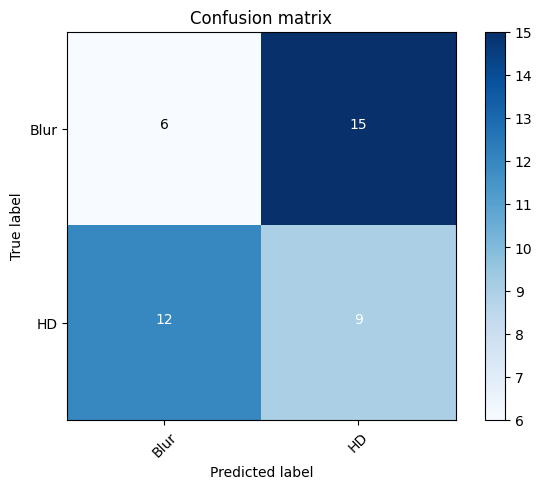

In [84]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(validation_generator, validation_generator.samples // batch_size+1)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors
Y_true = validation_generator.classes

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Class names
class_names = ['Blur','HD']

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix with class names
plot_confusion_matrix(confusion_mtx, classes=class_names)


In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                

In [75]:
class_indices = train_generator.class_indices
print(class_indices)

{'Blur': 0, 'HD': 1}


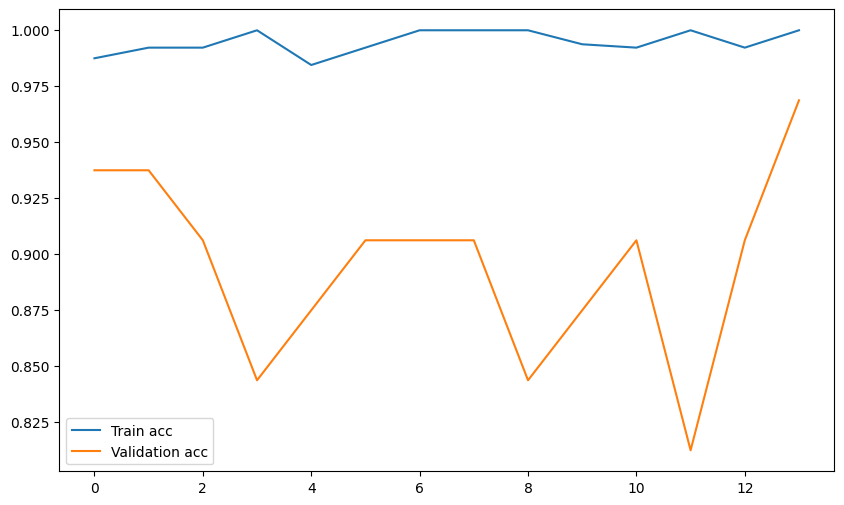

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

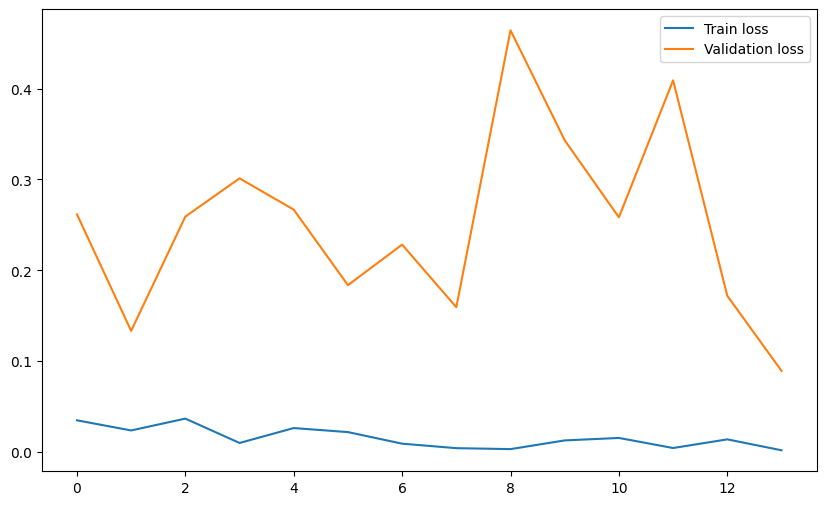

In [87]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


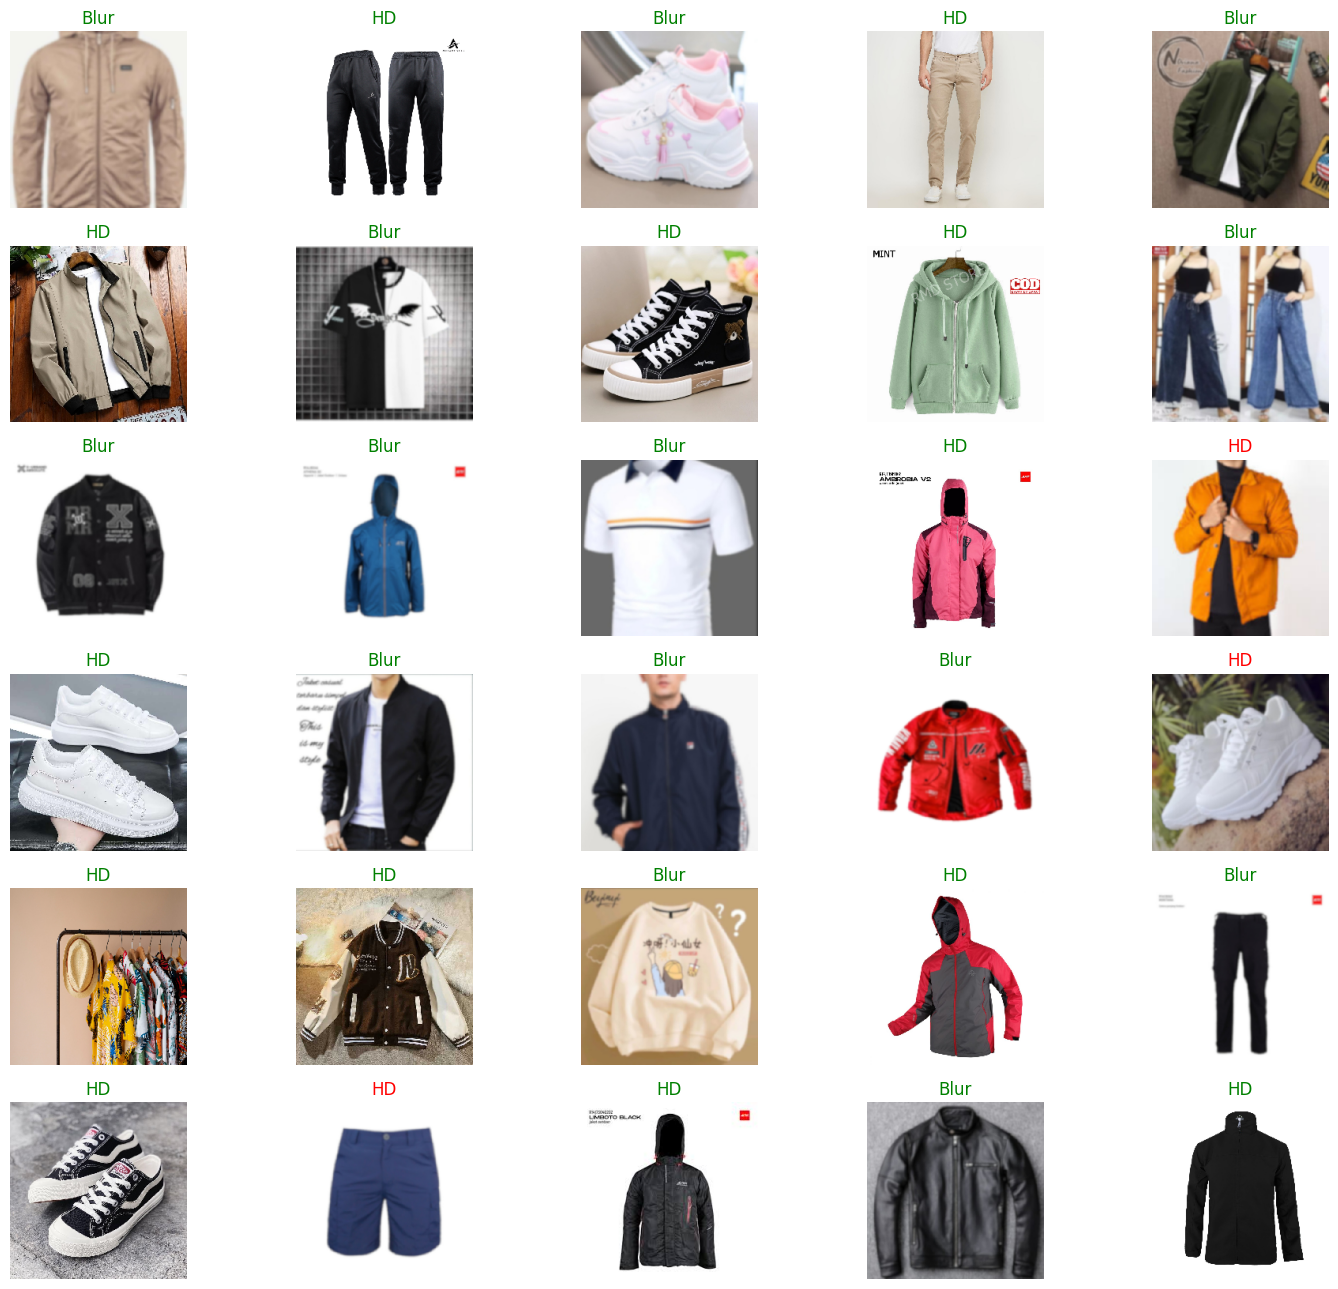

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/content/model.h5')

# Assuming validation_generator is already set up and is part of the code that was provided
# Make sure to use the correct directory for the validation data
# validation_generator = ...

# Get a batch of images from the validation generator
img, labels = next(validation_generator)

# Define the class indices (mapping) as obtained previously
class_indices = {'Blur': 0, 'HD': 1}

# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i])

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
